# MLP Model

Code transferred over from Colab:
https://colab.research.google.com/drive/1nH1WuabNUx2wiX3UwHi_cYxwkJ78i12n?usp=sharing

In [56]:
# Import statements
import tensorflow as tf
import keras_tuner
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import h5py
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


# Plot formatting defaults
plt.rc('ytick', direction='out')
plt.rc('grid', color='w', linestyle='solid')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', direction='out')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [2]:
# Tensorboard stuff
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

from tensorboard.plugins.hparams import api as hp

In [29]:
# Load in train and test data

mat = scipy.io.loadmat('W8_samples.mat')
W8_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W9_samples.mat')
W9_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W10_samples.mat')
W10_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W5_samples.mat')
W5_cell_data = mat['cell_data']

del mat

X_train, y_train = shuffle(W8_cell_data[:,1:], W8_cell_data[:,0])

X_test = W9_cell_data[:,1:]
y_test = W9_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_train = np.transpose(np.reshape(X_train, (X_train.shape[0], 2, int(X_train.shape[1]/2))), (0, 2, 1))
X_test = np.transpose(np.reshape(X_test, (X_test.shape[0], 2, int(X_test.shape[1]/2))), (0, 2, 1))

# Split into two vectors: one for voltage, one for current
X_trainVolts = X_train[:,:,0]
X_trainAmps = X_train[:,:,1]
X_testVolts = X_test[:,:,0]
X_testAmps = X_test[:,:,1]

# Split off and reserve dev set from train set
X_trainVolts, X_devVolts, X_trainAmps, X_devAmps, y_train, y_dev = train_test_split(X_trainVolts, X_trainAmps, y_train, test_size=0.1, shuffle= True)

# Save dimensions for LSTM
n_feat = X_train.shape[1]

#W10 cell data
X_test_W10 = W10_cell_data[:,1:]
y_test_W10 = W10_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W10 = np.transpose(np.reshape(X_test_W10, (X_test_W10.shape[0], 2, int(X_test_W10.shape[1]/2))), (0, 2, 1))

X_testVolts_W10 = X_test_W10[:,:,0]
X_testAmps_W10 = X_test_W10[:,:,1]

#W5 cell data
X_test_W5 = W5_cell_data[:,1:]
y_test_W5 = W5_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W5 = np.transpose(np.reshape(X_test_W5, (X_test_W5.shape[0], 2, int(X_test_W5.shape[1]/2))), (0, 2, 1))

X_testVolts_W5 = X_test_W5[:,:,0]
X_testAmps_W5 = X_test_W5[:,:,1]

print(X_trainVolts.shape)
print(X_trainAmps.shape)


(72811, 1200)
(72811, 1200)


In [6]:
# Rescale output to min 0, max 1:
min_max_scaler = MinMaxScaler().fit(np.concatenate((y_train, y_test, y_dev, y_test_W10, y_test_W5)).reshape((-1,1)))

y_train_scaled = min_max_scaler.transform(y_train.reshape((-1,1))).reshape(-1,)
y_test_scaled = min_max_scaler.transform(y_test.reshape((-1,1))).reshape(-1,)
y_dev_scaled = min_max_scaler.transform(y_dev.reshape((-1,1))).reshape(-1,)
y_test_W10_scaled = min_max_scaler.transform(y_test_W10.reshape((-1,1))).reshape(-1,)
y_test_W5_scaled = min_max_scaler.transform(y_test_W5.reshape((-1,1))).reshape(-1,)

In [7]:
# Downsample train and dev by 1/10th for testing
X_trainVolts_ds = X_trainVolts[0::10, :]
X_trainAmps_ds = X_trainAmps[0::10, :]
y_train_ds = y_train_scaled[0::10]

X_devVolts_ds = X_devVolts[0::10, :]
X_devAmps_ds = X_devAmps[0::10, :]
y_dev_ds = y_dev_scaled[0::10]

print(X_trainVolts_ds.shape)
print(X_trainAmps_ds.shape)
print(y_train_ds.shape)

print(X_devVolts_ds.shape)
print(X_devAmps_ds.shape)
print(y_dev_ds.shape)

(7282, 1200)
(7282, 1200)
(7282,)
(810, 1200)
(810, 1200)
(810,)


## Fitting via KerasTuner:
See https://keras.io/guides/keras_tuner/getting_started/ and https://keras.io/guides/keras_tuner/visualize_tuning/

In [50]:
def build_model(hp):

    # Set ranges for each layer of the MLP:
    layer_UB = [2400, 1200, 600, 300, 150]
    layer_LB = [1200, 600, 300, 100, 20]
    layer_step = [600, 300, 100, 100, 20]

    model = keras.Sequential()
    model.add(keras.Input(2400,))
    # Tune the number of layers.
    n_layers = hp.Int("num_layers", 1, 4)
    for i in range(n_layers):
        model.add(
            layers.Dense(
                units=hp.Choice(f"units_{i}", [600, 1200, 2400]),
                activation="relu",
            )
        )
    # if hp.Boolean("dropout"):
    #     model.add(layers.Dropout(rate=0.25))
    model.add(
        layers.Dense(
                units=hp.Choice("units_3rd_to_last", [50, 100, 200]),
                activation="relu"
            )
    )
    model.add(
        layers.Dense(
                units=hp.Choice("units_2nd_to_last", [10, 20, 50]),
                activation="relu"
            )
    )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mean_squared_error",
        metrics=["mean_squared_error"],
    )
    return model


In [51]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mean_squared_error",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="/tmp/tb",
    project_name="mlp",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units_0 (Choice)
{'default': 600, 'conditions': [], 'values': [600, 1200, 2400], 'ordered': True}
units_3rd_to_last (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 200], 'ordered': True}
units_2nd_to_last (Choice)
{'default': 10, 'conditions': [], 'values': [10, 20, 50], 'ordered': True}


In [52]:
tuner.search(
    np.hstack((X_trainVolts_ds, X_trainAmps_ds)),
    y_train_ds,
    validation_data=(np.hstack((X_devVolts_ds, X_devAmps_ds)), y_dev_ds),
    batch_size=500,
    epochs=5,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 20 Complete [00h 00m 05s]
val_mean_squared_error: 0.12243997678160667

Best val_mean_squared_error So Far: 0.12162067741155624
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit


In [53]:
# Get the top model
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(X_test.shape[1],))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1200)              2881200   
                                                                 
 dense_1 (Dense)             (None, 600)               720600    
                                                                 
 dense_2 (Dense)             (None, 600)               360600    
                                                                 
 dense_3 (Dense)             (None, 200)               120200    
                                                                 
 dense_4 (Dense)             (None, 10)                2010      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,084,621
Trainable params: 4,084,621
Non-

In [ ]:
tuner.results_summary()

In [ ]:
# # Train model with optimal hyperparameters from above
# def build_hp_model():

#     model = keras.Sequential()
#     model.add(keras.Input(2400,))
#     model.add(layers.Dense(1200, activation="relu"))
#     model.add(layers.Dense(1200, activation="relu"))
#     model.add(layers.Dense(2400, activation="relu"))
#     model.add(layers.Dense(200, activation="relu"))
#     model.add(layers.Dense(20, activation="relu"))
#     model.add(layers.Dense(1, activation="linear"))
#     model.compile(
#         optimizer=keras.optimizers.Adam(),
#         loss="mean_squared_error",
#         metrics=["mean_squared_error"],
#     )
#     return model
# hp_model = build_hp_model()
# hp_model.summary()


## Train the model

In [54]:
history = best_model.fit(np.hstack((X_trainVolts, X_trainAmps)),
                    y_train_scaled,
                    epochs=5000,
                    verbose=2,
                    batch_size=500,
                    validation_data=(np.hstack((X_devVolts, X_devAmps)), y_dev_scaled)
                    )

best_model.save("MLP_v2_w8_5000_MSE")

Epoch 1/5000


2022-05-29 14:52:46.408459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 14:52:49.322842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 - 3s - loss: 0.1262 - mean_squared_error: 0.1262 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - 3s/epoch - 24ms/step
Epoch 2/5000
146/146 - 2s - loss: 0.1232 - mean_squared_error: 0.1232 - val_loss: 0.1232 - val_mean_squared_error: 0.1232 - 2s/epoch - 17ms/step
Epoch 3/5000
146/146 - 2s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 2s/epoch - 16ms/step
Epoch 4/5000
146/146 - 2s - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1214 - val_mean_squared_error: 0.1214 - 2s/epoch - 15ms/step
Epoch 5/5000
146/146 - 2s - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1214 - val_mean_squared_error: 0.1214 - 2s/epoch - 16ms/step
Epoch 6/5000
146/146 - 2s - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1213 - val_mean_squared_error: 0.1213 - 2s/epoch - 16ms/step
Epoch 7/5000
146/146 - 2s - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1212 - val_mean_squared_error: 0.1212 - 2s/epoch - 15ms/ste

## Model validation (MSE)

### Validation on W9 cell

2222/2222 [==============================] - 5s 2ms/step


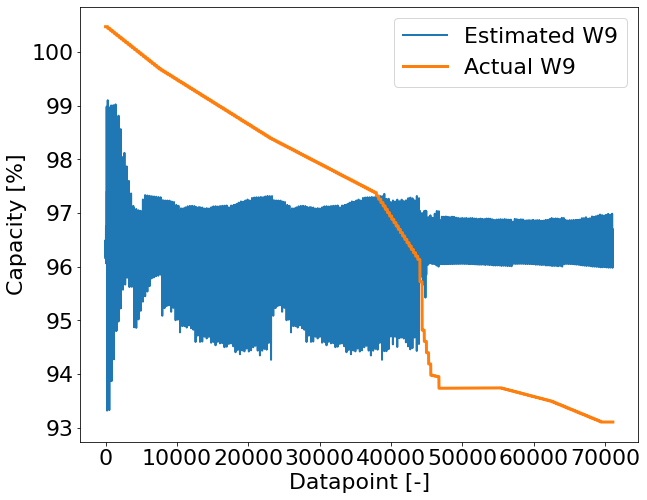

0.06527038258592309


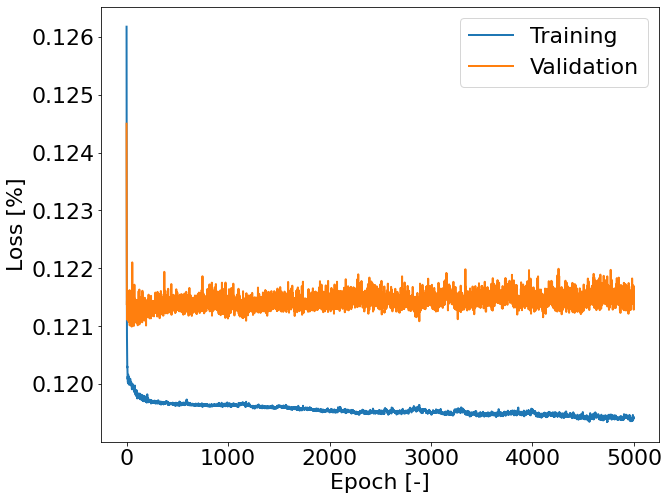

In [58]:
# y_hat = hp_model.predict(np.hstack((X_testVolts, X_testAmps)))
# # y_hat_plot = min_max_scaler.inverse_transform(y_hat_scaled.reshape((-1,1)))
# y_test_plot = min_max_scaler.inverse_transform(y_test_scaled.reshape((-1,1)))
# plt.plot(np.ravel(y_hat))
# plt.plot(y_test*100, linewidth=3)

y_hat_scaled = best_model.predict(np.hstack((X_testVolts, X_testAmps)))
y_hat_plot = min_max_scaler.inverse_transform(y_hat_scaled.reshape((-1,1)))
y_test_plot = min_max_scaler.inverse_transform(y_test_scaled.reshape((-1,1)))
plt.plot(y_hat_plot*100)
plt.plot(y_test_plot*100, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
# best_model.evaluate(np.hstack((X_testVolts, X_testAmps)), y_test, verbose=2)
print(mean_squared_error(y_hat_plot, y_test_plot)*100)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch [-]")
plt.ylabel("Loss [%]")
plt.show()


### Validation on W10 cell

2304/2304 [==============================] - 5s 2ms/step


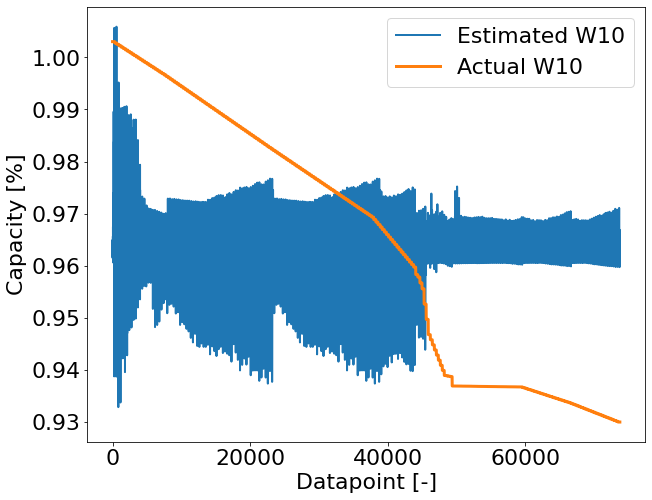

0.06160314927879932


In [59]:
# Validate on W10 cell

# mat = scipy.io.loadmat('W10_samples.mat')
# W10_cell_data = mat['cell_data']

# del mat

# X_test_W10 = W10_cell_data[:,1:]
# y_test_W10 = W10_cell_data[:,0]*100

# # Downsample test by 1/10th
# y_test_W10 = y_test_W10[0::10]
# X_test_W10 = X_test_W10[0::10, :]

y_hat_scaled_W10 = best_model.predict(np.hstack((X_testVolts_W10, X_testAmps_W10)))

y_hat_plot_W10 = min_max_scaler.inverse_transform(y_hat_scaled_W10.reshape((-1,1)))
y_test_plot_W10 = min_max_scaler.inverse_transform(y_test_W10_scaled.reshape((-1,1)))
plt.plot(y_hat_plot_W10)
plt.plot(y_test_plot_W10, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
# best_model.evaluate(X_test_W10, y_test_W10, verbose=2)
print(mean_squared_error(y_hat_plot_W10, y_test_plot_W10)*100)



### Validation on W5 cell

2671/2671 [==============================] - 6s 2ms/step


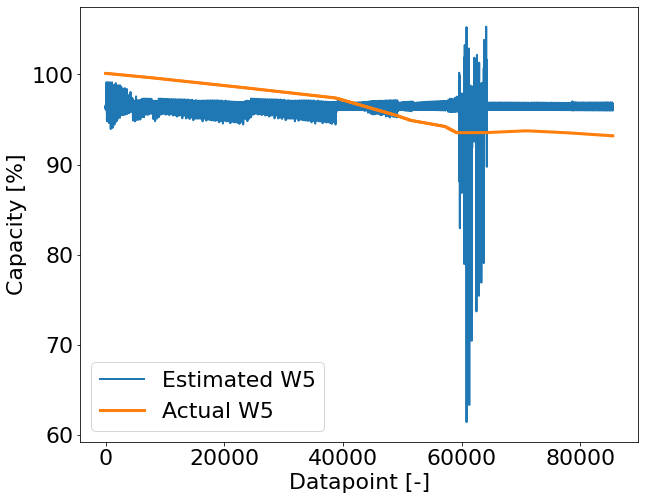

0.05966381838532257


In [60]:
# Validate on W5 cell

# mat = scipy.io.loadmat('W5_samples.mat')
# W5_cell_data = mat['cell_data']

# del mat

# X_test_W5 = W5_cell_data[:,1:]
# y_test_W5 = W5_cell_data[:,0]*100

# # Downsample test by 1/10th
# y_test_W5 = y_test_W5[0::10]
# X_test_W5 = X_test_W5[0::10, :]

# y_hat_W5 = best_model.predict(X_test_W5)

y_hat_scaled_W5 = best_model.predict(np.hstack((X_testVolts_W5, X_testAmps_W5)))

y_hat_plot_W5 = min_max_scaler.inverse_transform(y_hat_scaled_W5.reshape((-1,1)))
y_test_plot_W5 = min_max_scaler.inverse_transform(y_test_W5_scaled.reshape((-1,1)))
plt.plot(y_hat_plot_W5*100)
plt.plot(y_test_W5*100, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
# best_model.evaluate(X_test_W5, y_test_W5, verbose=2)
print(mean_squared_error(y_hat_plot_W5, y_test_plot_W5)*100)


## Model Validation (MAE)

In [ ]:
# Load model
hp_model = keras.models.load_model("mymodel_w8_5000")

### Validation on W9 cell

2222/2222 [==============================] - 6s 3ms/step


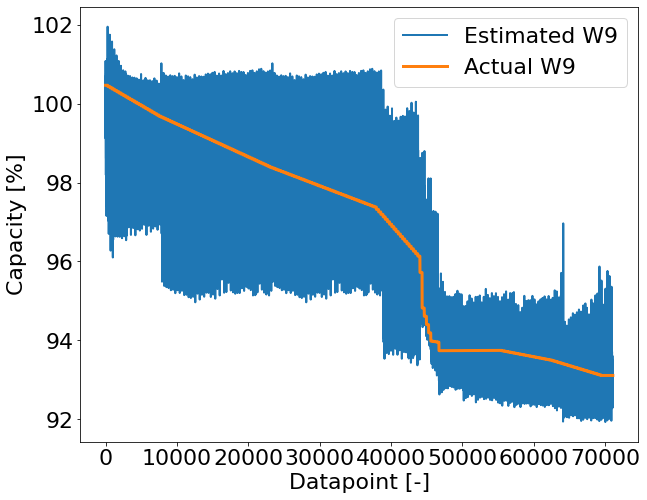

1.1541456276056652


In [67]:
y_hat = hp_model.predict(np.hstack((X_testVolts, X_testAmps)))
# y_hat_plot = min_max_scaler.inverse_transform(y_hat_scaled.reshape((-1,1)))
y_test_plot = min_max_scaler.inverse_transform(y_test_scaled.reshape((-1,1)))
plt.plot(np.ravel(y_hat))
plt.plot(y_test_plot*100, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
# best_model.evaluate(np.hstack((X_testVolts, X_testAmps)), y_test, verbose=2)
print(mean_squared_error(y_hat, y_test_plot*100))

### Validation on W10 cell

2304/2304 [==============================] - 6s 3ms/step


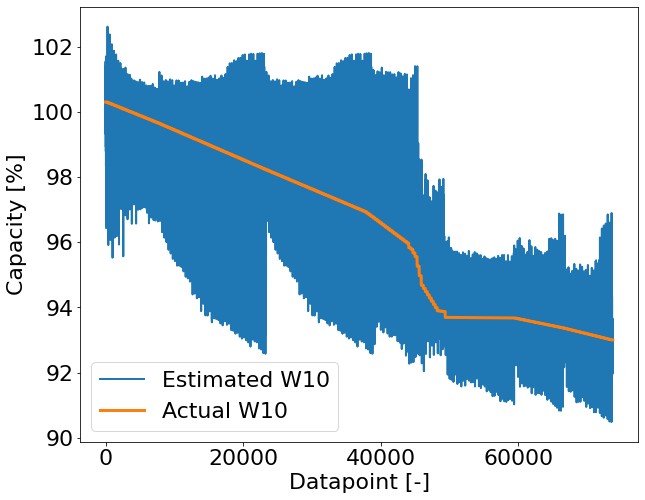

2.221373896428827


In [68]:
# Validate on W10 cell

y_hat_scaled_W10 = hp_model.predict(np.hstack((X_testVolts_W10, X_testAmps_W10)))
# y_hat_plot = min_max_scaler.inverse_transform(y_hat_scaled.reshape((-1,1)))
y_test_plot_W10 = min_max_scaler.inverse_transform(y_test_W10_scaled.reshape((-1,1)))
plt.plot(np.ravel(y_hat_scaled_W10))
plt.plot(y_test_plot_W10*100, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
# best_model.evaluate(np.hstack((X_testVolts, X_testAmps)), y_test, verbose=2)
print(mean_squared_error(y_hat_scaled_W10, y_test_plot_W10*100))

### Validation on W5 cell

2671/2671 [==============================] - 7s 3ms/step


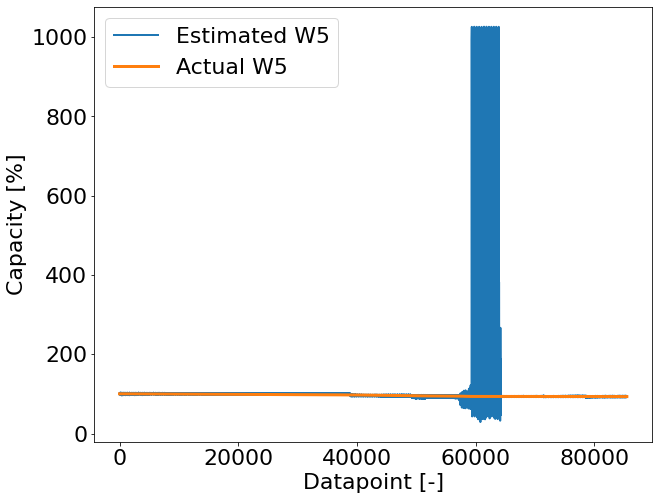

6143.190587421118


In [70]:
# Validate on W5 cell

y_hat_scaled_W5 = hp_model.predict(np.hstack((X_testVolts_W5, X_testAmps_W5)))
# y_hat_plot = min_max_scaler.inverse_transform(y_hat_scaled.reshape((-1,1)))
y_test_plot_W5 = min_max_scaler.inverse_transform(y_test_W5_scaled.reshape((-1,1)))
plt.plot(np.ravel(y_hat_scaled_W5))
plt.plot(y_test_plot_W5*100, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
# best_model.evaluate(np.hstack((X_testVolts, X_testAmps)), y_test, verbose=2)
print(mean_squared_error(y_hat_scaled_W5, y_test_plot_W5*100))

In [ ]:
|